## 基础变量定义

In [29]:
import os
print(os.getcwd())

test_image_dir = "./pseudo_bdd100k_dataset/images/10k/train"  
test_mask_dir = "./pseudo_bdd100k_dataset/labels/sem_seg/masks/train"

image_list = os.listdir(test_image_dir)
image_name = image_list[2].split(".jpg")[0]

image_path = os.path.join(test_image_dir,image_name+".jpg")
mask_path = os.path.join(test_mask_dir,image_name+".png")

print(f"test image path is: {image_path}")
print(f"test mask path is: {mask_path}")

/Users/huangshan/Documents/DailyStudy/mmsegmentation/TestPR
test image path is: ./pseudo_bdd100k_dataset/images/10k/train/00067cfb-e535423e.jpg
test mask path is: ./pseudo_bdd100k_dataset/labels/sem_seg/masks/train/00067cfb-e535423e.png


In [46]:
import mmcv
from mmengine.structures import PixelData
from mmseg.structures import SegDataSample
# from  mmseg.visualization.local_visualizer import SegLocalVisualizer

save_dir = './work_dirs'

seg_local_visualizer = SegLocalVisualizer(vis_backends=[dict(type='LocalVisBackend')],
                                          save_dir=save_dir,
                                          dataset_name = "cityscapes")

image = mmcv.imread(image_path,channel_order='rgb')

sem_seg = mmcv.imread(mask_path,'unchanged')
gt_sem_seg_data = dict(data=sem_seg)
gt_sem_seg = PixelData(**gt_sem_seg_data)

gt_seg_data_sample = SegDataSample()
gt_seg_data_sample.gt_sem_seg = gt_sem_seg

In [9]:
%matplotlib osx

## Opencv

### 完整函数

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from mmseg.utils.class_names import cityscapes_classes,cityscapes_palette

def get_center_loc(mask):
    mask = mask.astype(np.uint8)
    height = mask.shape[0]
    loc = np.argwhere(mask==1)
    
    # 中间坐标 8邻域
    xmin_loc = np.argmin(loc[:,1],axis=0)
    xmax_loc = np.argmax(loc[:,1],axis=0)
    ymin_loc = np.argmin(loc[:,0],axis=0)
    ymax_loc = np.argmax(loc[:,0],axis=0)
    x_mean_loc = (loc[xmin_loc,1]+loc[xmax_loc,1])//2
    y_mean_loc = (loc[ymin_loc,0]+loc[ymax_loc,0])//2
    # print(f"xmin_loc is {loc[xmin_loc,1]}, xmax_loc is {loc[xmax_loc,1]}, mean loc_x {x_mean_loc}")
    # print(f"ymin_loc is {loc[ymin_loc,0]}, ymax_loc is {loc[ymax_loc,0]}, mean loc_y {y_mean_loc}")
    if np.array([y_mean_loc,x_mean_loc]) in loc:
        # print("mean loc exists")
        return np.array([x_mean_loc,y_mean_loc])
    for ystep in [-1,0,1]:
        for xstep in [-1,0,1]:
            new_loc = np.array([y_mean_loc+ystep,x_mean_loc+xstep])
            if new_loc in loc:
                return np.array([x_mean_loc+xstep,y_mean_loc+ystep])
            continue
    # 排序取中间
    loc_sort = np.array(sorted(loc.tolist(), key=lambda row: (row[0],row[1])))
    # print(loc_sort[-5:-1,:])
    center_num = len(loc_sort)//2
    x = loc_sort[center_num][1]
    y = loc_sort[center_num][0]
    return np.array([x,y])

def get_most_freq_loc(mask,offset=20):
    mask = mask.astype(np.uint8)
    width = mask.shape[1]
    height = mask.shape[0]
    loc = np.argwhere(mask==1)
    
    # 对于所有的x，x值相同的点的个数越多，即y范围越大，说明这条线越长，视觉上越主要，但是由于显示label是横着的字，
    # 所以是对于y来说，相同y的点越多越好。
    loc_sort = np.array(sorted(loc.tolist(), key=lambda row: (row[0],row[1])))
    y_list = loc_sort[:,0]
    unique, indices, counts = np.unique(y_list, return_index=True,return_counts=True)
    y_loc = unique[counts.argmax()]
    print(f"counts max value is :{y_loc}, corresping index in y_list is {indices[counts.argmax()]}")
    y_most_freq_loc = loc[loc_sort[:,0]==y_loc]
    center_num = len(y_most_freq_loc)//2
    x = y_most_freq_loc[center_num][1]
    y = y_most_freq_loc[center_num][0]
    # x= x-offset if x>width-offset else x
    # x= x+offset if x<offset else x
    # y = y-offset if y>height-offset else y
    # y= y+offset if y<offset else y      
    return np.array([x,y])
    
def _draw_sem_seg(image, sem_seg,classes,palette,withLabels = False):
    alpha=1
    num_classes = len(classes)

    sem_seg = sem_seg.cpu().data
    ids = np.unique(sem_seg)[::-1]
    legal_indices = ids < num_classes
    ids = ids[legal_indices]
    labels = np.array(ids, dtype=np.int64)
    print(f"labels:{labels}, len(labels) is {len(labels)}")

    colors = [palette[label] for label in labels]
   
    mask = np.zeros_like(image, dtype=np.uint8)
    for label, color in zip(labels, colors):
        mask[sem_seg[0] == label, :] = color
    if withLabels:
        font = cv2.FONT_HERSHEY_SIMPLEX
        # this value can be from 0 to 1 (0,1] to change the size of the text relative to the image
        scale = 0.05
        fontScale = min(image.shape[0], image.shape[1])/(25/scale)
        fontColor = (255, 255, 255)
        if image.shape[0] < 300 or image.shape[1] < 300:
            thickness = 1
            rectangleThickness = 1
        else:
            thickness = 2
            rectangleThickness = 2
        lineType = 2

        if isinstance(sem_seg[0], torch.Tensor):
            masks = sem_seg[0].numpy() == labels[:, None, None]
        else:
            masks = sem_seg[0] == labels[:, None, None]
        masks = masks.astype(np.uint8)
        for mask_num in range(len(labels)):
            classes_id = labels[mask_num]
            classes_color = colors[mask_num]
            loc = get_most_freq_loc(masks[mask_num])
            text = classes[classes_id]
            (label_width, label_height), baseline = cv2.getTextSize(
                text, font, fontScale, thickness)
            mask = cv2.rectangle(mask, loc,
                                 (loc[0] + label_width + baseline,
                                  loc[1] + label_height + baseline),
                                 classes_color, -1)
            mask = cv2.rectangle(mask, loc,
                                 (loc[0] + label_width + baseline,
                                  loc[1] + label_height + baseline),
                                 (0, 0, 0), rectangleThickness)
            mask = cv2.putText(mask, text, (loc[0], loc[1] + label_height),
                               font, fontScale, fontColor, thickness,
                               lineType)
        color_seg = (image * (1 - alpha) + mask * alpha).astype(np.uint8)
        plt.imshow(color_seg) 
    return color_seg

masks = _draw_sem_seg(image, gt_sem_seg,classes=cityscapes_classes(),palette=cityscapes_palette(),withLabels=True)

labels:[15 13 11 10  8  7  6  5  2  1  0], len(labels) is 11
counts max value is :374, corresping index in y_list is 1831
counts max value is :398, corresping index in y_list is 2039
counts max value is :424, corresping index in y_list is 9007
counts max value is :0, corresping index in y_list is 0
counts max value is :186, corresping index in y_list is 115942
counts max value is :265, corresping index in y_list is 2731
counts max value is :344, corresping index in y_list is 1105
counts max value is :110, corresping index in y_list is 2290
counts max value is :253, corresping index in y_list is 144376
counts max value is :518, corresping index in y_list is 30981
counts max value is :603, corresping index in y_list is 117337


### 测试草稿

cv2.putText: <https://www.geeksforgeeks.org/python-opencv-cv2-puttext-method/>

In [5]:
import numpy as np
a=np.array([[1,2],[3,4],[5,2],[5,5],[5,3],[1,4]])
xmaxLoc = np.argmax(a[:,0],axis=0)
print(a[xmaxLoc,0])
ymaxLoc = np.argmax(a[:,1],axis=0)
print(a[ymaxLoc,1])

5
5


In [6]:
sorted(a.tolist(), key=lambda row: (row[0],row[1]))

[[1, 2], [1, 4], [3, 4], [5, 2], [5, 3], [5, 5]]

In [7]:
np.array([1,2]) in a

True

直接排序，取中间的一个loc其实也行。。。

Opencv获取绘制的Text文本框的高度和宽度：
+ <https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga3d2abfcb995fd2db908c8288199dba82>
+ <https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga3d2abfcb995fd2db908c8288199dba82>
+ <https://stackoverflow.com/questions/51285616/opencvs-gettextsize-and-puttext-return-wrong-size-and-chop-letters-with-low>

Opencv绘制矩形+Text
+ <https://stackoverflow.com/questions/56108183/python-opencv-cv2-drawing-rectangle-with-text>
+ 填充矩形，thickness值设置为-1即可。<https://www.geeksforgeeks.org/python-opencv-cv2-rectangle-method>

## matplotlib

### 完整函数

In [144]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from mmseg.utils.class_names import cityscapes_classes,cityscapes_palette

def get_most_freq_loc(mask,offset=20):
    mask = mask.astype(np.uint8)
    width = mask.shape[1]
    height = mask.shape[0]
    loc = np.argwhere(mask==1)

    loc_sort = np.array(sorted(loc.tolist(), key=lambda row: (row[0],row[1])))
    y_list = loc_sort[:,0]
    unique, indices, counts = np.unique(y_list, return_index=True,return_counts=True)
    y_loc = unique[counts.argmax()]
    # print(f"counts max value is :{y_loc}, corresping index in y_list is {indices[counts.argmax()]}")
    y_most_freq_loc = loc[loc_sort[:,0]==y_loc]
    center_num = len(y_most_freq_loc)//2
    x = y_most_freq_loc[center_num][1]
    y = y_most_freq_loc[center_num][0]
    return np.array([x,y])

def _draw_sem_seg(image, sem_seg,classes,palette,withLabels = False):
    alpha=1
    num_classes = len(classes)

    sem_seg = sem_seg.cpu().data
    ids = np.unique(sem_seg)[::-1]
    legal_indices = ids < num_classes
    ids = ids[legal_indices]
    labels = np.array(ids, dtype=np.int64)
    print(f"labels:{labels}, len(labels) is {len(labels)}")

    colors = [palette[label] for label in labels]
   
    if withLabels:
        fig,ax = plt.subplots()
        
        masks = sem_seg[0] == labels[:, None, None]
        mask = np.zeros_like(image, dtype=np.uint8)
        for label, color in zip(labels, colors):
            mask[sem_seg[0] == label, :] = color
        color_seg = (image * (1 - alpha) + mask * alpha).astype(np.uint8)
        ax.imshow(mask)
        ax.set_yticks([])
        ax.set_xticks([])
        width = mask.shape[1]
        height = mask.shape[0]
        print(f"width: {width}")
        
        fontsize=14
        for mask_num in range(len(labels)):
            classes_id = labels[mask_num]
            classes_color = colors[mask_num]
            text = classes[classes_id]
            
            loc = get_most_freq_loc(masks[mask_num])
            print(f"loc is {loc}")
            
            # r = fig.canvas.get_renderer()
            # t = plt.text(loc[0],loc[1]+12,text)
            # bb = t.get_window_extent(renderer=r)
            # text_width = bb.width
            # text_height = bb.height
            # print(f"text_width: {text_width}, text_height: {text_height}")
            
            
            # print("Dot per inch(DPI) for the figure is: ", fig.dpi)
            # 这个计算和上面结果基本一致。。。
            bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            text_height = height/fig.dpi/bbox.height*fontsize
            text_width = width/fig.dpi/bbox.width*fontsize*len(text)
            # print(f"text_width: {text_width}, text_height: {text_height}")
            
            ax.annotate(
                text=text,
                xy=np.array([loc[0],loc[1]+12]),
                xytext=(text_width*(-0.5) if loc[0]< width//2 else width+text_width*0.5, loc[1]),
                xycoords="data",
                arrowprops={"arrowstyle": "->", "color": "black"},
                color="black",
                fontsize=fontsize,
                horizontalalignment="center"
            )
        
        # fig.subplots_adjust(left=0.4)
        # color_seg = ax.get_images()
        # print("List of the Axes images contained by the Axes \n",*list(ax.get_images()), sep ="\n")
    return color_seg

masks = _draw_sem_seg(image, gt_sem_seg,classes=cityscapes_classes(),palette=cityscapes_palette(),withLabels=True)
plt.imshow(masks)

labels:[15 13 11 10  8  7  6  5  2  1  0], len(labels) is 11
width: 1280
loc is [ 19 374]
loc is [1139  398]
loc is [865 424]
loc is [1109    0]
loc is [369 186]
loc is [527 265]
loc is [563 344]
loc is [512 110]
loc is [574 253]
loc is [518 518]
loc is [640 603]


### 测试草稿

+ 主要是使用annotation的方式，参考：<https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/tools.py>
+ 获取text的长度和高度：
    + <https://stackoverflow.com/questions/5320205/matplotlib-text-dimensions>
    + <https://matplotlib.org/3.1.1/api/text_api.html#matplotlib.text.Text.set_fontsize>
    + <https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_size_units.html>
+ ax.annotate的箭头样式：<https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.ArrowStyle.html>
+ 获取ax的image：
    + <https://www.geeksforgeeks.org/matplotlib-axes-axes-get_images-in-python/>
    + <https://stackoverflow.com/questions/25505341/how-to-get-the-axesimages-from-matplotlib>
+ 保存时包含annotate：
    + <https://stackoverflow.com/questions/56361175/why-is-picture-annotation-cropped-when-displaying-or-saving-figure/56370990#56370990>
    + <https://stackoverflow.com/questions/29901422/matplotlib-with-annotation-cut-off-from-the-saved-figure>

## 写入local_visualizer.py进行测试

In [1]:
import os
print(os.getcwd())

test_image_dir = "./pseudo_bdd100k_dataset/images/10k/train"  
test_mask_dir = "./pseudo_bdd100k_dataset/labels/sem_seg/masks/train"

image_list = os.listdir(test_image_dir)
image_name = image_list[0].split(".jpg")[0]

image_path = os.path.join(test_image_dir,image_name+".jpg")
mask_path = os.path.join(test_mask_dir,image_name+".png")

print(f"test image path is: {image_path}")
print(f"test mask path is: {mask_path}")

/Users/huangshan/Documents/DailyStudy/mmsegmentation/TestPR
test image path is: ./pseudo_bdd100k_dataset/images/10k/train/00054602-3bf57337.jpg
test mask path is: ./pseudo_bdd100k_dataset/labels/sem_seg/masks/train/00054602-3bf57337.png


In [2]:
%matplotlib osx

In [5]:
import numpy as np
import mmcv
from mmengine.structures import PixelData
from mmseg.structures import SegDataSample
from local_visualizer import SegLocalVisualizer

save_dir = './work_dirs'

seg_local_visualizer = SegLocalVisualizer(vis_backends=[dict(type='LocalVisBackend')],
                                          save_dir=save_dir,
                                          dataset_name = "cityscapes")

image = mmcv.imread(image_path,channel_order='rgb')

sem_seg = mmcv.imread(mask_path,'unchanged')
gt_sem_seg_data = dict(data=sem_seg)
gt_sem_seg = PixelData(**gt_sem_seg_data)

gt_seg_data_sample = SegDataSample()
gt_seg_data_sample.gt_sem_seg = gt_sem_seg
# gt_seg_data_sample.pred_sem_seg = gt_sem_seg

seg_local_visualizer.add_datasample('visualizer_example', image,gt_seg_data_sample, show=True,withLabels=True)

## 测试jupyter

In [9]:
!pip uninstall mmseg -y

In [1]:
import os
os.getcwd()

'/Users/huangshan/Documents/DailyStudy/mmsegmentation/TestPR'

IPython reload 改动库的问题：
+ <https://ipython.org/ipython-doc/3/config/extensions/autoreload.html>
+ <https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython>
+ <https://stackoverflow.com/questions/34758129/ipython-notebook-is-not-updating-when-i-change-my-code>

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from mmengine.model.utils import revert_sync_batchnorm
import mmseg.apis
from mmseg.apis import init_model, inference_model, show_result_pyplot

# import importlib
# importlib.reload(mmseg.apis)

In [4]:
config_file = '../configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py'
checkpoint_file = '../checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

model = init_model(config_file, checkpoint_file, device='cpu')

img = '../demo/demo.png'
if not torch.cuda.is_available():
    model = revert_sync_batchnorm(model)
result = inference_model(model, img)

/Users/huangshan/Documents/DailyStudy/openMMLabCampusLearn/selfExercise/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/Users/huangshan/Documents/DailyStudy/openMMLabCampusLearn/selfExercise/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


Loads checkpoint by local backend from path: ../checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


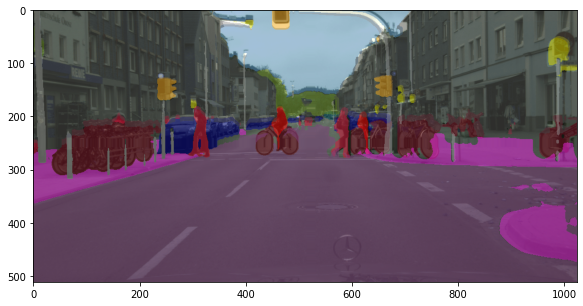

In [9]:
vis_result = show_result_pyplot(model, img, result, show=True)
plt.figure(figsize=(10,5))
plt.imshow(vis_result)

## 测试tests/test_visualization/test_local_visualizer.py

In [1]:
import os
os.getcwd()

'/Users/huangshan/Documents/DailyStudy/mmsegmentation/TestPR'

In [39]:
import cv2
import mmcv
import numpy as np
import torch
from mmengine.structures import PixelData

from mmseg.structures import SegDataSample
# from  mmseg.visualization.local_visualizer import SegLocalVisualizer
# from mmseg.visualization import SegLocalVisualizer
from local_visualizer import SegLocalVisualizer
import tempfile

import os.path as osp

def test_cityscapes_add_datasample():
    h = 128
    w = 256
    num_class = 19
    out_file = 'out_file_cityscapes'

    image = mmcv.imread(
            '../tests/data/pseudo_cityscapes_dataset/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png',
        'color')
    sem_seg = mmcv.imread(
            '../tests/data/pseudo_cityscapes_dataset/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelTrainIds.png'  # noqa,
        ,'unchanged')
    sem_seg = torch.unsqueeze(torch.from_numpy(sem_seg), 0)
    gt_sem_seg_data = dict(data=sem_seg)
    gt_sem_seg = PixelData(**gt_sem_seg_data)

    def test_cityscapes_add_datasample_forward(gt_sem_seg):
        data_sample = SegDataSample()
        data_sample.gt_sem_seg = gt_sem_seg

        with tempfile.TemporaryDirectory() as tmp_dir:
            seg_local_visualizer = SegLocalVisualizer(
                vis_backends=[dict(type='LocalVisBackend')],
                save_dir=tmp_dir)
            seg_local_visualizer.dataset_meta = dict(
                classes=('road', 'sidewalk', 'building', 'wall', 'fence',
                         'pole', 'traffic light', 'traffic sign',
                         'vegetation', 'terrain', 'sky', 'person', 'rider',
                         'car', 'truck', 'bus', 'train', 'motorcycle',
                         'bicycle'),
                palette=[[128, 64, 128], [244, 35, 232], [70, 70, 70],
                         [102, 102, 156], [190, 153, 153], [153, 153, 153],
                         [250, 170, 30], [220, 220, 0], [107, 142, 35],
                         [152, 251, 152], [70, 130, 180], [220, 20, 60],
                         [255, 0, 0], [0, 0, 142], [0, 0, 70],
                         [0, 60, 100], [0, 80, 100], [0, 0, 230],
                         [119, 11, 32]])
            # test out_file
            seg_local_visualizer.add_datasample(
                out_file,
                image,
                data_sample,
                out_file=osp.join(tmp_dir, 'test.png'),
                show=True)

            # test gt_instances and pred_instances
            pred_sem_seg_data = dict(
                data=torch.randint(0, num_class, (1, h, w)))
            pred_sem_seg = PixelData(**pred_sem_seg_data)

            data_sample.pred_sem_seg = pred_sem_seg

            # test draw prediction with gt
            seg_local_visualizer.add_datasample(out_file, image,
                                                data_sample)
            # test draw prediction without gt
            seg_local_visualizer.add_datasample(
                out_file, image, data_sample, draw_gt=False)
    
test_cityscapes_add_datasample()

### 拆成函数测试

In [35]:
h = 128
w = 256
num_class = 19
out_file = 'out_file_cityscapes'

image = mmcv.imread(
        '../tests/data/pseudo_cityscapes_dataset/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png',
    'color')
sem_seg = mmcv.imread(
        '../tests/data/pseudo_cityscapes_dataset/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelTrainIds.png'  # noqa,
    ,'unchanged')
sem_seg = torch.unsqueeze(torch.from_numpy(sem_seg), 0)
gt_sem_seg_data = dict(data=sem_seg)
gt_sem_seg = PixelData(**gt_sem_seg_data)

In [37]:
masks = _draw_sem_seg(image, sem_seg,classes=cityscapes_classes(),palette=cityscapes_palette(),withLabels=True)
plt.imshow(masks)

labels:[13 11 10  8  7  5  4  2  1  0], len(labels) is 10
counts max value is :53, corresping index in y_list is 757
loc x is 53, y is 179, text = car
counts max value is :52, corresping index in y_list is 42
loc x is 52, y is 150, text = person
counts max value is :3, corresping index in y_list is 82
loc x is 3, y is 124, text = sky
counts max value is :18, corresping index in y_list is 107
loc x is 18, y is 123, text = vegetation
counts max value is :31, corresping index in y_list is 70
loc x is 31, y is 51, text = traffic sign
counts max value is :19, corresping index in y_list is 62
loc x is 19, y is 137, text = pole
counts max value is :50, corresping index in y_list is 6
loc x is 50, y is 121, text = fence
counts max value is :37, corresping index in y_list is 7389
loc x is 37, y is 138, text = building
counts max value is :71, corresping index in y_list is 461
loc x is 71, y is 40, text = sidewalk
counts max value is :111, corresping index in y_list is 8389
loc x is 111, y is 11